In [1]:
%load_ext autoreload
%autoreload 2
import logging
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

import math
import time
from dnafiber.postprocess.core import Fibers
import cv2
from dnafiber.data.utils import load_image
from dnafiber.model.utils import (
    get_ensemble_models,
    get_error_detection_model,
    _get_model,
    Models,
)
from dnafiber.deployment import run_one_file

for name, l in logging.root.manager.loggerDict.items():
    if "streamlit" in name:
        l.disabled = True

2026-02-10 12:48:42.855 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-02-10 12:48:50.295 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-02-10 12:48:50.297 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-02-10 12:48:50.298 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2026-02-10 12:48:50.301 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-10 12:48:50.303 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2026-02-10 12:48:50.304 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ig

In [2]:
sint_file = Path("/media/clement/HD/Yosra/YM-2025-20/2025-05-16/siNT-01.czi")

ensemble_models = get_ensemble_models()
single_model = _get_model(Models.UNET_SE_RESNET50).cuda()
detection_model = get_error_detection_model().cuda()
image_blurred = dict()

image = load_image(
    sint_file,
    True,
)
N_steps = (
    5 * 2 * 2
)  # 5 sigma values, with and without TTA, for both single and ensemble models
progress_bar = tqdm(total=N_steps, desc="Processing images with different noise levels")
with progress_bar:
    for model_name, model in zip(
        ["single_model", "ensemble_models"], [single_model, ensemble_models]
    ):
        for use_tta in [False, True]:
            for sigma in np.linspace(0, 24, 5):
                ksize = int(2 * math.ceil(3 * sigma) + 1)
                if sigma == 0:
                    gaussian_blurred = image
                else:
                    gaussian_blurred = cv2.GaussianBlur(image, (ksize, ksize), sigma)
                image_blurred[sigma] = gaussian_blurred
                output_filepath = Path(
                    f"results/prediction_sigma_{sigma}_model_{model_name}_tta_{use_tta}.pkl"
                )
                if output_filepath.exists():
                    progress_bar.update(1)
                    continue
                prediction: Fibers = run_one_file(
                    gaussian_blurred,
                    model=model,
                    use_tta=use_tta,
                    pixel_size=0.13,
                    verbose=True,
                    error_detection_model=detection_model,
                )
                prediction.to_pickle(output_filepath)
                progress_bar.update(1)

DiceScore metric currently defaults to `average=micro`, but will change to`average=macro` in the v1.9 release. If you've explicitly set this parameter, you can ignore this warning.


Processing images with different noise levels:   0%|          | 0/20 [00:00<?, ?it/s]

In [3]:
from skimage.util import random_noise
import numpy as np

sigmas = np.linspace(0, 1, 5)
N_steps = len(sigmas) * 2 * 2
image_noisy = dict()


progress_bar = tqdm(total=N_steps, desc="Processing images with different noise levels")
with progress_bar:
    for model_name, model in zip(
        ["single_model", "ensemble_models"], [single_model, ensemble_models]
    ):
        for use_tta in [False, True]:
            for sigma in sigmas:
                if sigma == 0:
                    noisy = image
                else:
                    noisy = (
                        random_noise(image, mode="gaussian", var=sigma**2, clip=True)
                        * 255
                    ).astype(np.uint8)
                image_noisy[sigma] = noisy
                output_filepath = Path(
                    f"results/prediction_noise_sigma_{sigma}_model_{model_name}_tta_{use_tta}.pkl"
                )
                if output_filepath.exists():
                    progress_bar.update(1)
                    continue
                else:
                    prediction: Fibers = run_one_file(
                        noisy,
                        model=model,
                        use_tta=use_tta,
                        pixel_size=0.13,
                        verbose=True,
                        error_detection_model=detection_model,
                    )
                    prediction.to_pickle(
                        f"results/prediction_noise_sigma_{sigma}_model_{model_name}_tta_{use_tta}.pkl"
                    )
                    progress_bar.update(1)

Processing images with different noise levels:   0%|          | 0/20 [00:00<?, ?it/s]

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


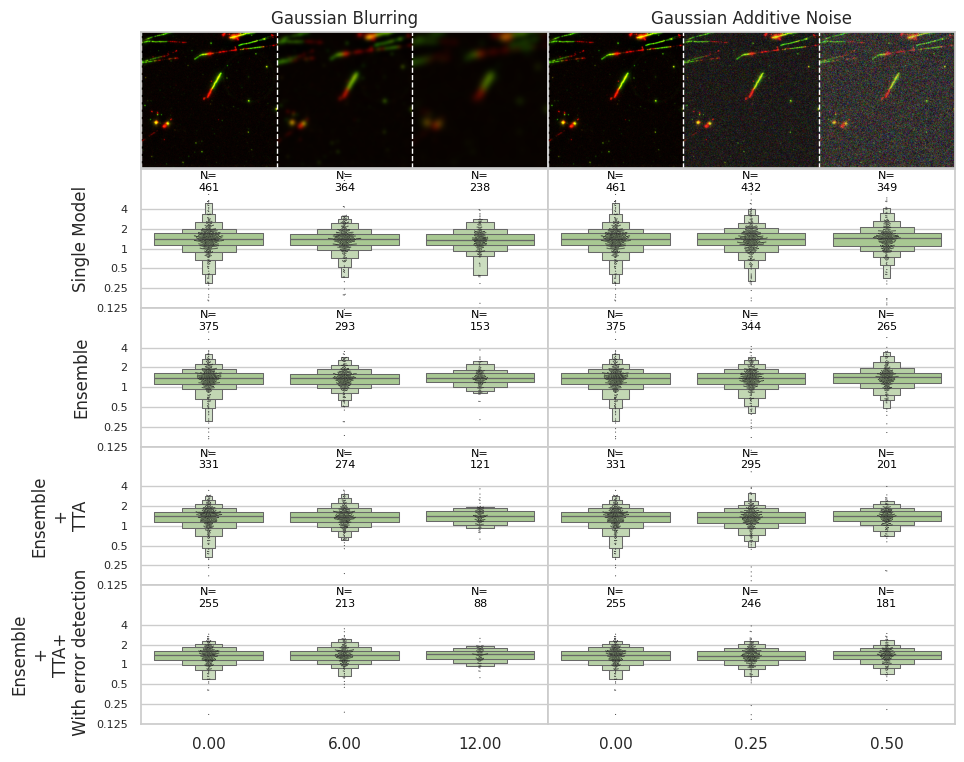

In [29]:
# --- Load predictions from pickles into dataframes ---
configs = [
    ("single_model", False, "Single Model"),
    # ("single_model", True, "Single Model\n+\nTTA"),
    ("ensemble_models", False, "Ensemble"),
    ("ensemble_models", True, "Ensemble\n+\nTTA"),
    ("ensemble_models", True, "Ensemble\n+\nTTA+\n With error detection"),
]

blur_sigmas = np.linspace(0, 24, 5)[:-2]
noise_sigmas = np.linspace(0, 1, 5)[:-2]

dfs_blurred = []
dfs_noise = []

for model_name, use_tta, _ in configs:
    rows_blur = []
    rows_noise = []
    for sigma in blur_sigmas:
        pred = Fibers.from_pickle(
            f"results/prediction_sigma_{sigma}_model_{model_name}_tta_{use_tta}.pkl"
        )
        df = pred.to_df(img_name=sint_file.stem, filter_invalid=True)
        df["Type"] = "-".join(sint_file.stem.split("-")[:-1])
        df["sigma"] = sigma
        rows_blur.append(df)
    for sigma in noise_sigmas:
        pred = Fibers.from_pickle(
            f"results/prediction_noise_sigma_{sigma}_model_{model_name}_tta_{use_tta}.pkl"
        )
        df = pred.to_df(img_name=sint_file.stem, filter_invalid=True)
        df["Type"] = "-".join(sint_file.stem.split("-")[:-1])
        df["sigma"] = sigma
        rows_noise.append(df)
    dfs_blurred.append(pd.concat(rows_blur, ignore_index=True))
    dfs_noise.append(pd.concat(rows_noise, ignore_index=True))

# --- Plotting ---
names = [name for _, _, name in configs]

sns.set_theme(style="whitegrid")
scale = 0.75
fig, axes = plt.subplots(len(configs) + 1, 2, figsize=(14 * scale, 12 * scale))

# Manually share x-axis only among boxen/swarm rows (skip row 0 = images)
for col in range(2):
    for row in range(2, len(configs) + 1):
        axes[row, col].sharex(axes[1, col])


for current_f, (df_blurred, df_noise) in enumerate(zip(dfs_blurred, dfs_noise)):
    for j, df in enumerate([df_blurred, df_noise]):
        if current_f == len(configs) - 1:
            df = df[df["Error probability"] <= 0.5]
        ax = axes[current_f + 1, j]
        sns.boxenplot(
            x="sigma",
            y="Ratio",
            hue="Type",
            data=df,
            ax=ax,
            dodge=True,
            palette=["#a6d189"],
            legend=None,
            showfliers=False,
        )
        sns.swarmplot(
            x="sigma",
            y="Ratio",
            hue="Type",
            data=df,
            ax=ax,
            palette="dark:black",
            legend=None,
            s=0.75,
        )
        if current_f == len(configs) - 1:
            ax.set_xticklabels([f"{sigma:.2f}" for sigma in df["sigma"].unique()])
        else:
            ax.set_xticklabels([])
        ax.set_xlabel("")
        ax.set_yscale("log")
        ax.set_yticks([0.125, 0.25, 0.5, 1, 2, 4], [0.125, 0.25, 0.5, 1, 2, 4])
        ax.set_ylim(0.125, 16)
        if j == 1:
            ax.set_yticklabels([])
            ax.set_ylabel("")
        else:
            ax.tick_params(axis="y", which="major", labelsize=8)
            ax.set_ylabel(f"{names[current_f]}")
        # Add fiber count annotations
        for i, sigma in enumerate(df["sigma"].unique()):
            count = df[df["sigma"] == sigma].shape[0]
            ax.text(
                i,
                7,
                f"N=\n{count}",
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
            )

# --- Top row: image previews ---
start = 4900
length = 512
subset_indices_y = slice(start + 200, start + 200 + length)
subset_indices_x = slice(start, start + length)

for i, (ax, title, sigmas, image_dict) in enumerate(
    zip(
        axes[0, :],
        ["Gaussian Blurring", "Gaussian Additive Noise"],
        [blur_sigmas, noise_sigmas],
        [image_blurred, image_noisy],
    )
):
    ax.set_ylim(0, 1)
    ax.set_xlim(0, len(sigmas))
    ax.set_yscale("linear")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    for j, s in enumerate(sigmas):
        img1 = image_dict[s][subset_indices_y, subset_indices_x]
        ax.imshow(img1, extent=[j, j + 1, 0, 1])
        ax.axvline(j, color="white", linestyle="--", linewidth=1)

plt.subplots_adjust(hspace=0.0, wspace=0)
plt.savefig("noise_robustness_comparison.png", dpi=300, bbox_inches="tight")

In [24]:
df

,Fiber ID,First analog (µm),Second analog (µm),Ratio,Fiber type,Valid,Error probability,Image Name,Type,sigma
0,1,5.720000,19.760000,3.454545,two segments,True,0.984155,siNT-01,siNT,0.0
1,2,12.870000,21.970000,1.707071,two segments,True,0.047248,siNT-01,siNT,0.0
2,7,27.742406,21.450000,0.773185,termination,True,0.052946,siNT-01,siNT,0.0
3,8,11.158024,19.240000,1.724320,two segments,True,0.045663,siNT-01,siNT,0.0
4,16,9.078024,17.420000,1.918920,two segments,True,0.048533,siNT-01,siNT,0.0
...,...,...,...,...,...,...,...,...,...,...
925,40,11.880071,11.418024,0.961107,two segments,True,0.041538,siNT-01,siNT,1.0
926,48,9.100000,13.541096,1.488033,two segments,True,0.139748,siNT-01,siNT,1.0
927,51,9.376004,12.740000,1.358788,two segments,True,0.657453,siNT-01,siNT,1.0
928,55,6.462067,9.240759,1.430001,two segments,True,0.123655,siNT-01,siNT,1.0
